In [2]:
import librosa as lr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot

Sample rate:  22050
Sample type:  <class 'numpy.ndarray'>
Sample legth:  203213


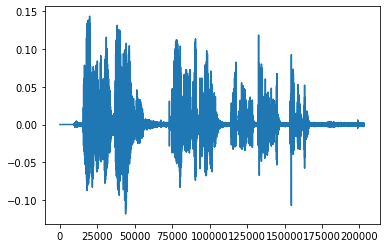

In [5]:
# Load sample 
soundSample, sr = lr.load('vs1.mp3')

# Plot sample
pyplot.figure(1)
pyplot.plot(soundSample)

print("Sample rate: ", sr)
print("Sample type: " , type(soundSample))
print("Sample legth: " , len(soundSample))

<class 'numpy.ndarray'>
(257, 1588)


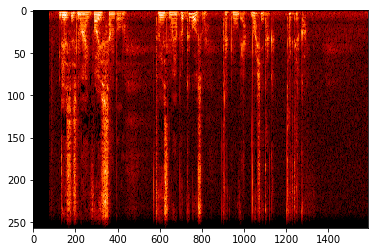

In [6]:
# Calculate the Short-Time Fourier Transformate
# n_fft = 512 for speech is recommened (default is 2048)
S = np.abs(lr.stft(soundSample, n_fft=512))

# Switch to lagarytmic scale
S = lr.power_to_db(S**2,ref=np.max)

pyplot.figure(1)
pyplot.imshow(S, cmap='gist_heat', aspect ='auto')

# Whot is the type of S ?
print(type(S))
print(S.shape)


(257, 56)


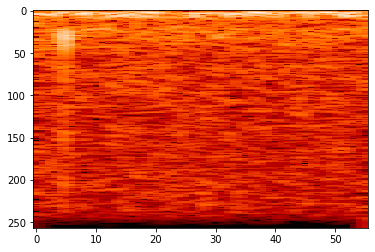

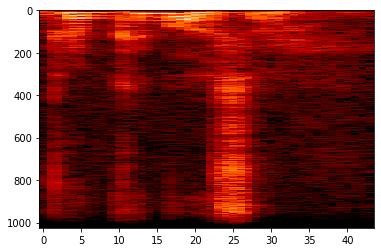

In [9]:
# Get 1 sek signal
# Calibrate the hop_length that the outup dimetions are equal 

fragment = 9
soundSample_s = soundSample[sr*fragment:sr*(1+fragment)]
S_s = np.abs(lr.stft(soundSample_s, n_fft = 512, hop_length = round(sr/256))) # hop length adjusted
S_s = lr.power_to_db(S_s**2,ref=np.max)

pyplot.figure(1)
pyplot.imshow(S_s, cmap='gist_heat', aspect ='auto')
print(S_s.shape)

fragment = 4
soundSample_s_no_hop = soundSample[sr*fragment:sr*(1+fragment)]
S_sno_hop = np.abs(lr.stft(soundSample_s_no_hop))
S_sno_hop = lr.power_to_db(S_sno_hop**2,ref=np.max)

pyplot.figure(2)
pyplot.imshow(S_sno_hop, cmap='gist_heat', aspect ='auto')

In [9]:
print(len(soundSample_s))

22050


In [10]:
# Crop to 256x256 

print(S_s.shape)
print(S_s[0:256,0:256].shape)

Signal = S_s[0:256,0:256]
print(type(Signal))

signal_size = 256


(257, 257)
(256, 256)
<class 'numpy.ndarray'>


Directly konverted to torch.tensor:  torch.Size([256, 256]) <class 'torch.Tensor'>
After reshape:  torch.Size([256, 256]) <class 'torch.Tensor'>
Data type:  torch.float32
Convolution output:  torch.Size([1, 16, 128, 128])


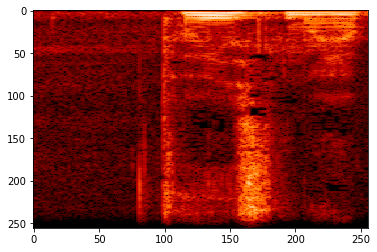

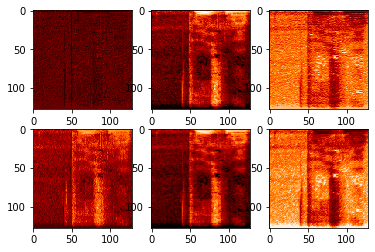

In [16]:
# Convert numpy to tensor

tsignal = torch.tensor(Signal)
print("Directly konverted to torch.tensor: " , tsignal.shape, type(tsignal))

pyplot.imshow(tsignal,cmap='gist_heat', aspect ='auto')


# Conv needs 4 arguments (4 dimentional tensor)
# View is tensor reshape (as reshape in numpy)
image_pro = tsignal.view(-1, 1, signal_size, signal_size)

print("After reshape: " , tsignal.shape, type(tsignal))
print("Data type: ", tsignal.dtype)


# Define convolution
convT = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
# Convolution input 
Cj2 = convT(image_pro)

print("Convolution output: ", Cj2.shape)

# We can't view the object that requires_gradient = True 
Cj2 = Cj2.detach()

# Convolutions plot (6 from 16)
pyplot.figure(2)
channel = 16
for i in range(0,6):
    pyplot.subplot(2,3,i+1)
    pyplot.imshow(Cj2[0,i],cmap='gist_heat', aspect ='auto')

In [4]:
import librosa as lr


def LoadSoundSamples(coreName, samplesPath=None):
    
    n = 1
    soundSamples = [],[]
    
    
    while(True):
        try:
            if samplesPath:
                soundSample, sr = lr.load(samplesPath + coreName + str(n))
            else:
                soundSample, sr = lr.load(coreName + str(n))
            
        except FileNotFoundError:
            if len(soundSamples)>0:
                print("That's the end of database")
                return soundSamples
            else:
                print("Files are missing")
            break
            
        except Exception as ex:
            print("Unexpected error: " , ex)
            break
        
        n += 1
        soundSamples[0].append(soundSample)
        soundSamples[1].append(sr)    


sampleList = LoadSoundSamples("vs")
#print(sampleList[0][0])
#print(sampleList[1][0])
print(sampleList)

/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


That's the end of database
([array([-9.0211279e-06, -8.3625609e-06,  2.4894875e-06, ...,
       -5.7567819e-04, -1.1265196e-03,  0.0000000e+00], dtype=float32), array([-9.0211279e-06, -8.3625609e-06,  2.4894875e-06, ...,
       -5.7567819e-04, -1.1265196e-03,  0.0000000e+00], dtype=float32)], [22050, 22050])


/home/krys/.local/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [46]:
def ChopToOneSecFragments(soundSample, sr):
    
    chopedSoundSamples = [],[]
    
    frag_max = math.trunc(len(soundSample)/float(sr))
    step = math.trunc(sr/2);
    last_sample = len(soundSample)
      
    for frag in range(frag_max*2):
        start = step * frag
        stop = start + sr
        if sr<len(soundSample):
            chopedSoundSamples[0].append(soundSample[start:stop])
            chopedSoundSamples[1].append(sr)
        else:
            print("Something went wrong!")
        
        # incuding samples cuted by math.trunc() 
        chopedSoundSamples[0].append(soundSample[last_sample-sr:last_sample])
        chopedSoundSamples[1].append(sr)
        
    return chopedSoundSamples
            
s_sample = sampleList[0][0]
s_sr = sampleList[1][0] 
#print(ChopToOneSecFragments(s_sample, s_sr))


([array([ 0.        ,  0.        ,  0.        , ..., -0.01062595,
       -0.0169697 ,  0.01683212], dtype=float32), array([ 0.00013878, -0.00036792, -0.00032546, ..., -0.0005686 ,
       -0.00114202,  0.        ], dtype=float32), array([-0.00193803, -0.00067759, -0.00245284, ...,  0.01520957,
        0.01469205,  0.01259229], dtype=float32), array([ 0.00013878, -0.00036792, -0.00032546, ..., -0.0005686 ,
       -0.00114202,  0.        ], dtype=float32), array([-0.03418618, -0.0087924 , -0.01806513, ..., -0.02343074,
        0.02979889, -0.0657037 ], dtype=float32), array([ 0.00013878, -0.00036792, -0.00032546, ..., -0.0005686 ,
       -0.00114202,  0.        ], dtype=float32), array([ 0.01358163,  0.01530437,  0.01595159, ..., -0.00327556,
       -0.00229628, -0.00123972], dtype=float32), array([ 0.00013878, -0.00036792, -0.00032546, ..., -0.0005686 ,
       -0.00114202,  0.        ], dtype=float32), array([ 0.0599501 , -0.00696404, -0.01984174, ...,  0.00084987,
        0.00151427,  0

In [ ]:
def Samples_To_STFT_Image(soundSamples):
    for sound in soundSamples:
        

In [43]:
import math

print(math.trunc(156.9))

156


In [7]:
##############################################################################
#                        Not shure if i want to use it
##############################################################################

import librosa as lr

# Create a dataset class

class VoiceSampleDataset(Dataset):
    """Voice Samples dataset."""

    def __init__(self, sample_name, root_dir = None, transform = None):

        self.soundSample, self.sr = lr.load(sample_name)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [68]:
import logging
 
logging.basicConfig(level=logging.INFO)
myLog = log.getLogger()

myLog.warning("This is warning")
myLog.Exeption("This is warning")
myLog.info("This shit is info")
myLog.debug("This shit")

AttributeError: 'RootLogger' object has no attribute 'Exeption'

In [18]:
num = [1,2,5,6,2,3]
for n in range(len(num)):
    num[n] = num[n]**2
print(sum(num))

79
